# 0) Title and Setup

* Notebook Title: DSA4213 Assignment 3 - Topic Detection on AG News with DistilBERT using 2 fine-tuning strategies  which are Full Fine-tuning and LoRA


# 1) Setup & Environment

I installed all required libraries (`transformers`, `datasets`, `evaluate`, `peft`, `accelerate`) and confirmed GPU availability in Google Colab. This ensured a stable environment for fine-tuning experiments.

In [1]:
# 1.1 Install core libraries
# !pip -q install transformers datasets evaluate peft accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00


In [11]:
# 1.2 Imports & GPU check
import torch, random, numpy as np, time, os, psutil

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected — training will be slow.")

GPU: Tesla T4


In [12]:
# 1.3 Set random seeds (reproducibility)
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# (Optional) ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Seeds set:", SEED)

Seeds set: 42


In [13]:
# 1.4 Utilities for logging parameters, runtime, and memory
def count_trainable_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    pct = 100 * trainable / total if total else 0.0
    return {"total": total, "trainable": trainable, "pct": pct}

def start_timer():
    if torch.cuda.is_available():
        try:
            torch.cuda.reset_peak_memory_stats()
        except Exception:
            pass
    return time.time()

def end_timer(t0):
    elapsed_s = time.time() - t0
    peak_vram_mb = None
    if torch.cuda.is_available():
        try:
            peak_vram_mb = torch.cuda.max_memory_allocated() / 1e6
        except Exception:
            peak_vram_mb = None
    return {"elapsed_s": elapsed_s, "peak_vram_mb": peak_vram_mb}

print("Utils ready: count_trainable_params, start_timer, end_timer")

Utils ready: count_trainable_params, start_timer, end_timer


# 2) Data Ingestion

I imported the AG News dataset from Kaggle, inspected its structure (`Class Index`, `Title`, `Description`), and merged the title and description into a single `text` field. We cleaned the dataset, mapped class indices (1–4) to labels (0–3 with names World, Sports, Business, Sci/Tech), and created train/validation/test splits.

In [15]:
# 2.1 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# 2.2 Set dataset paths
DATA_DIR = "/content/drive/MyDrive/assignment3/data"
TRAIN_CSV = f"{DATA_DIR}/train.csv"
TEST_CSV  = f"{DATA_DIR}/test.csv"

import os
print("Found files?" , os.path.exists(TRAIN_CSV), os.path.exists(TEST_CSV))
print("Train CSV:", TRAIN_CSV)
print("Test  CSV:", TEST_CSV)

Found files? True True
Train CSV: /content/drive/MyDrive/assignment3/data/train.csv
Test  CSV: /content/drive/MyDrive/assignment3/data/test.csv


In [17]:
# 2.3 Load CSVs with pandas
import pandas as pd

train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

print("Train columns:", train_df.columns.tolist())
print("Test  columns:", test_df.columns.tolist())
print("Train size:", len(train_df), " Test size:", len(test_df))
train_df.head()

Train columns: ['Class Index', 'Title', 'Description']
Test  columns: ['Class Index', 'Title', 'Description']
Train size: 120000  Test size: 7600


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


## 2.4 Data Cleaning and Preparation

In [18]:
# 2.4.1 Check missing values (NA) before cleaning
na_train = train_df.isna().sum()
na_test  = test_df.isna().sum()
print("NA counts (train):\n", na_train, "\n")
print("NA counts (test):\n",  na_test)

NA counts (train):
 Class Index    0
Title          0
Description    0
dtype: int64 

NA counts (test):
 Class Index    0
Title          0
Description    0
dtype: int64


In [19]:
# 2.4.2 Drop/Fill NA and keep only essential columns
# - Keep rows with a label and at least a Title
# - If Description is NA, fill with empty string (we'll still use Title)
REQUIRED_LABEL_COL = "Class Index"
TITLE_COL = "Title"
DESC_COL  = "Description"

# Ensure these columns exist (matching your CSV schema)
assert all(c in train_df.columns for c in [REQUIRED_LABEL_COL, TITLE_COL, DESC_COL])
assert all(c in test_df.columns  for c in [REQUIRED_LABEL_COL, TITLE_COL, DESC_COL])

def clean_na(df):
    df = df.copy()
    # Drop rows with missing label or missing title
    df = df[~df[REQUIRED_LABEL_COL].isna()]
    df = df[~df[TITLE_COL].isna()]
    # Fill missing descriptions with empty string
    df[DESC_COL] = df[DESC_COL].fillna("")
    # Cast to proper types
    df[REQUIRED_LABEL_COL] = df[REQUIRED_LABEL_COL].astype(int)
    df[TITLE_COL] = df[TITLE_COL].astype(str)
    df[DESC_COL]  = df[DESC_COL].astype(str)
    return df

train_df = clean_na(train_df)
test_df  = clean_na(test_df)

print("After NA handling → sizes:", len(train_df), len(test_df))
train_df.head()

After NA handling → sizes: 120000 7600


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [20]:
# 2.4.3 Merge Title + Description into a single 'text' column
def merge_text(df):
    text = (df[TITLE_COL].str.strip() + " " + df[DESC_COL].str.strip()).str.strip()
    return text

train_df["text"] = merge_text(train_df)
test_df["text"]  = merge_text(test_df)

# Keep only needed columns going forward
train_df = train_df[[REQUIRED_LABEL_COL, "text"]].reset_index(drop=True)
test_df  = test_df[[REQUIRED_LABEL_COL, "text"]].reset_index(drop=True)

train_df.head()

,Class Index,text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [21]:
# 2.4.4 Light text cleaning: remove control characters & normalize whitespace
import re

CTRL_CHARS = r'[\r\n\t\f\v]+'
ESC_SEQS   = r'\\[abfnrtv]'  # literal backslash escape sequences

def normalize_text_series(s):
    s = s.str.replace(CTRL_CHARS, ' ', regex=True)
    s = s.str.replace(ESC_SEQS, ' ', regex=True)
    s = s.str.replace(r'\s+', ' ', regex=True).str.strip()
    return s

train_df["text"] = normalize_text_series(train_df["text"])
test_df["text"]  = normalize_text_series(test_df["text"])

train_df["text"].head(3)

,text
0,Wall St. Bears Claw Back Into the Black (Reute...
1,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Oil and Economy Cloud Stocks' Outlook (Reuters...


In [22]:
# 2.4.5 Map Class Index (1..4) → labels (0..3) and attach label names
# Canonical AG News mapping after shifting:
# 0=World, 1=Sports, 2=Business, 3=Sci/Tech
label_names = ["World", "Sports", "Business", "Sci/Tech"]

def map_labels(df):
    labels = df[REQUIRED_LABEL_COL].astype(int)
    # Safety: ensure labels are within {1,2,3,4}, then shift
    assert set(labels.unique()).issubset({1,2,3,4}), "Unexpected label values outside 1..4"
    labels = labels - 1
    df = df.copy()
    df["labels"] = labels
    return df.drop(columns=[REQUIRED_LABEL_COL])

train_df = map_labels(train_df)
test_df  = map_labels(test_df)

print("Unique labels (train):", sorted(train_df["labels"].unique()))
print("Unique labels (test):",  sorted(test_df["labels"].unique()))
train_df.head()

Unique labels (train): [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Unique labels (test): [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


,text,labels
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


## 2.5) Build HuggingFace DatasetDict and create a validation split (10%)


In [23]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

train_df_split, val_df = train_df.pipe(
    lambda df: train_test_split(
        df, test_size=0.10, random_state=SEED, stratify=df["labels"]
    )
)

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df_split.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
})

for split in ds:
    print(f"{split:10s}", len(ds[split]))
ds

train      108000
validation 12000
test       7600


DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 7600
    })
})

## 2.6) Sanity checks: sample rows and label names

In [24]:
for split in ["train", "validation", "test"]:
    ex = ds[split][0]
    print(f"[{split}] text[:100]: {ex['text'][:100]!r}")
    print(f"[{split}] label id: {ex['labels']}  →  {label_names[ex['labels']]}")
    print("-"*60)


[train] text[:100]: '10 seconds that change everything ATHENS - Ten seconds. Barely time enough to tie a shoe, wash a gla'
[train] label id: 1  →  Sports
------------------------------------------------------------
[validation] text[:100]: 'Orange Unveils 3G Phones in Long-Delayed Launch LONDON/PARIS (Reuters) - Orange unveiled its third-g'
[validation] label id: 3  →  Sci/Tech
------------------------------------------------------------
[test] text[:100]: "Fears for T N pension after talks Unions representing workers at Turner Newall say they are 'disappo"
[test] label id: 2  →  Business
------------------------------------------------------------


# 3) Data Exploration

- I explored the dataset distribution across splits and confirmed each class was balanced. This gave confidence that the dataset was suitable for fair evaluation across all topics.

In [25]:
# Class distribution (train/val/test)
import pandas as pd

def dist_from_dataset(dset):
    return pd.Series(dset["labels"]).value_counts().sort_index()

train_dist = dist_from_dataset(ds["train"])
val_dist   = dist_from_dataset(ds["validation"])
test_dist  = dist_from_dataset(ds["test"])

print("Label names:", ["0: World", "1: Sports", "2: Business", "3: Sci/Tech"])
print("\nTrain distribution:\n", train_dist)
print("\nValidation distribution:\n", val_dist)
print("\nTest distribution:\n", test_dist)

Label names: ['0: World', '1: Sports', '2: Business', '3: Sci/Tech']

Train distribution:
 0    27000
1    27000
2    27000
3    27000
Name: count, dtype: int64

Validation distribution:
 0    3000
1    3000
2    3000
3    3000
Name: count, dtype: int64

Test distribution:
 0    1900
1    1900
2    1900
3    1900
Name: count, dtype: int64


# 4) Tokenization & Dataset Preparation

I loaded the `distilbert-base-uncased` tokenizer and applied it to the dataset, truncating/padding texts to a maximum sequence length of 128. Tokenized outputs included `input_ids`, `attention_mask`, and labels, formatted for PyTorch training.

In [26]:
# 4.1 Load tokenizer & define label maps
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
label2id = {v: k for k, v in id2label.items()}

print("Tokenizer loaded:", MODEL_NAME)
print("MAX_LEN:", MAX_LEN)

Tokenizer loaded: distilbert-base-uncased
MAX_LEN: 128


In [27]:
# 4.2 Tokenize datasets (headline+description already merged in 'text')
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding=False,      # dynamic padding via data collator
        max_length=MAX_LEN
    )

ds_tok = ds.map(tokenize_batch, batched=True, remove_columns=[])
# Keep 'text' for error analysis; Trainer will ignore non-tensor columns when we set format.
print(ds_tok)

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})


In [28]:
# 4.3 Set PyTorch format for training (input_ids, attention_mask, labels)
cols = ["input_ids", "attention_mask", "labels"]
for split in ["train", "validation", "test"]:
    ds_tok[split].set_format(type="torch", columns=cols)

print("Torch columns set:", cols)
for split in ["train","validation","test"]:
    ex = ds_tok[split][0]
    print(f"{split} example shapes:",
          {k: tuple(v.shape) if hasattr(v, "shape") else type(v) for k, v in ex.items() if k in cols})

Torch columns set: ['input_ids', 'attention_mask', 'labels']
train example shapes: {'labels': (), 'input_ids': (65,), 'attention_mask': (65,)}
validation example shapes: {'labels': (), 'input_ids': (64,), 'attention_mask': (64,)}
test example shapes: {'labels': (), 'input_ids': (32,), 'attention_mask': (32,)}


In [29]:
# 4.4 Data collator & sanity-check a small batch
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=None)  # dynamic padding

train_loader_preview = DataLoader(
    ds_tok["train"],
    batch_size=8,
    shuffle=True,
    collate_fn=data_collator
)

batch = next(iter(train_loader_preview))
print("Batch keys:", list(batch.keys()))
print("input_ids shape:", batch["input_ids"].shape)
print("attention_mask shape:", batch["attention_mask"].shape)
print("labels shape:", batch["labels"].shape)
print("Example input_ids first row (truncated):", batch["input_ids"][0][:30].tolist())

Batch keys: ['labels', 'input_ids', 'attention_mask']
input_ids shape: torch.Size([8, 72])
attention_mask shape: torch.Size([8, 72])
labels shape: torch.Size([8])
Example input_ids first row (truncated): [101, 7802, 3364, 1011, 4883, 4018, 18922, 1999, 16571, 9011, 1011, 3185, 2732, 9158, 18922, 1010, 3781, 1010, 2343, 10778, 6097, 22068, 9692, 1011, 23882, 1001, 4464, 1025, 1055, 2364]


# 5) Metrics & Evaluation Setup


In [30]:
# 5.1 Load metrics (Accuracy, Macro-F1) and define compute_metrics for Trainer
import evaluate
import numpy as np

metric_acc = evaluate.load("accuracy")
metric_f1  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc  = metric_acc.compute(predictions=preds, references=labels)["accuracy"]
    mf1  = metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "macro_f1": mf1}

In [31]:
# 5.2 Confusion matrix + classification report helpers
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

label_names = ["World", "Sports", "Business", "Sci/Tech"]

def plot_confusion_matrix(y_true, y_pred, labels=label_names, normalize=False, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True).clip(min=1)
    fig = plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title + (" (normalized)" if normalize else ""))
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha="right")
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2. if cm.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = f"{cm[i, j]:.2f}" if normalize else f"{cm[i, j]:.0f}"
            plt.text(j, i, val,
                     horizontalalignment="center",
                     verticalalignment="center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

def print_classification_report(y_true, y_pred, labels=label_names):
    print(classification_report(y_true, y_pred, target_names=labels, digits=4))

In [32]:
# 5.3 One-call evaluation helper to use after training
# Usage later: preds, labels = evaluate_split(trainer, ds_tok["test"], split_name="test")
def evaluate_split(trainer, dataset, split_name="eval"):
    out = trainer.predict(dataset)
    logits, labels = out.predictions, out.label_ids
    preds = np.argmax(logits, axis=-1)

    # Core metrics (mirror Trainer's compute_metrics)
    from statistics import mean
    acc  = (preds == labels).mean()
    # Macro-F1 via evaluate to stay consistent
    mf1  = metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]

    print(f"[{split_name}] Accuracy: {acc:.4f} | Macro-F1: {mf1:.4f}")
    print_classification_report(labels, preds, labels=label_names)
    plot_confusion_matrix(labels, preds, labels=label_names, normalize=False, title=f"{split_name} Confusion")
    plot_confusion_matrix(labels, preds, labels=label_names, normalize=True,  title=f"{split_name} Confusion")

    return preds, labels

# 6) Baseline

I trained a frozen DistilBERT model with only a linear classification head on top. This provided a lightweight baseline to compare against more resource-intensive strategies. Baseline achieved ~87% accuracy on the test set.

In [33]:
# 6.1 Load DistilBERT classifier & freeze encoder (baseline)
from transformers import AutoModelForSequenceClassification
import torch

MODEL_NAME = "distilbert-base-uncased"

baseline_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=4,
    id2label={0:"World",1:"Sports",2:"Business",3:"Sci/Tech"},
    label2id={"World":0,"Sports":1,"Business":2,"Sci/Tech":3}
)

# Freeze all encoder parameters; leave classifier head trainable
for name, param in baseline_model.named_parameters():
    if not name.startswith("classifier"):  # DistilBERT head is "classifier.*"
        param.requires_grad = False

# Sanity: how many params are trainable?
info = count_trainable_params(baseline_model)
print(f"Params (total): {info['total']:,} | (trainable): {info['trainable']:,} | {info['pct']:.4f}% trainable")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Params (total): 66,956,548 | (trainable): 3,076 | 0.0046% trainable


In [34]:
# 6.2 TrainingArguments
from transformers import TrainingArguments
import torch

args_baseline = TrainingArguments(
    output_dir="./runs_baseline_tmp",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=5e-4,
    num_train_epochs=2,          # quick baseline
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="no",
    load_best_model_at_end=False,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=42,
)

print(args_baseline)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

In [35]:
# 6.3 Train baseline
from transformers import Trainer

trainer_baseline = Trainer(
    model=baseline_model,
    args=args_baseline,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

t0 = start_timer()
train_out = trainer_baseline.train()
timing = end_timer(t0)

print(train_out)
print(f"Elapsed (s): {timing['elapsed_s']:.2f}")
print(f"Peak VRAM (MB): {timing['peak_vram_mb']:.1f}" if timing['peak_vram_mb'] is not None else "Peak VRAM: n/a")

/tmp/ipython-input-4106855703.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_baseline = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.427700,0.403718,0.870083,0.869968
2,0.402600,0.380012,0.872167,0.871999


TrainOutput(global_step=6750, training_loss=0.5073841821176034, metrics={'train_runtime': 201.0716, 'train_samples_per_second': 1074.244, 'train_steps_per_second': 33.57, 'total_flos': 5856783003837696.0, 'train_loss': 0.5073841821176034, 'epoch': 2.0})
Elapsed (s): 201.44
Peak VRAM (MB): 467.1


== Baseline: Validation ==


[validation] Accuracy: 0.8722 | Macro-F1: 0.8720
              precision    recall  f1-score   support

       World     0.8718    0.8770    0.8744      3000
      Sports     0.9516    0.9573    0.9545      3000
    Business     0.8340    0.8107    0.8222      3000
    Sci/Tech     0.8304    0.8437    0.8370      3000

    accuracy                         0.8722     12000
   macro avg     0.8719    0.8722    0.8720     12000
weighted avg     0.8719    0.8722    0.8720     12000



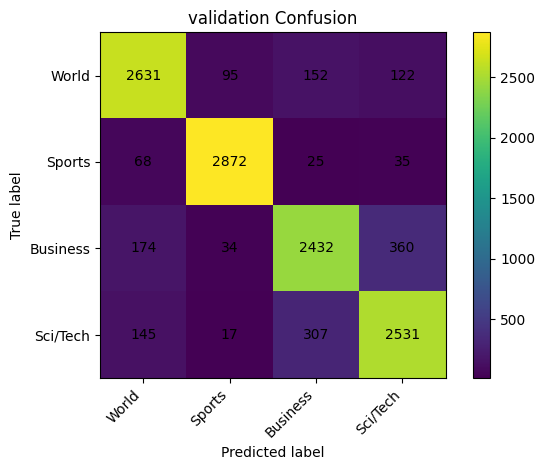

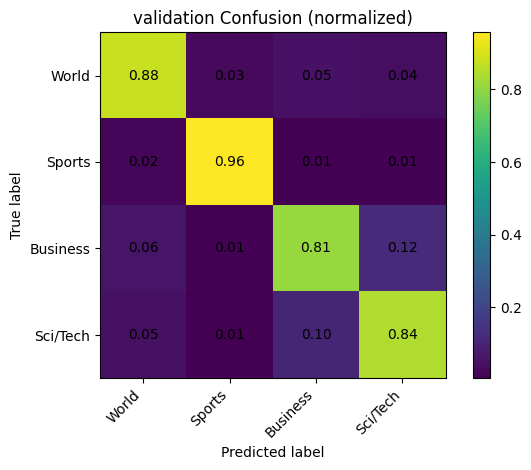

== Baseline: Test ==


[test] Accuracy: 0.8737 | Macro-F1: 0.8736
              precision    recall  f1-score   support

       World     0.8763    0.8726    0.8745      1900
      Sports     0.9540    0.9600    0.9570      1900
    Business     0.8270    0.8153    0.8211      1900
    Sci/Tech     0.8367    0.8468    0.8417      1900

    accuracy                         0.8737      7600
   macro avg     0.8735    0.8737    0.8736      7600
weighted avg     0.8735    0.8737    0.8736      7600



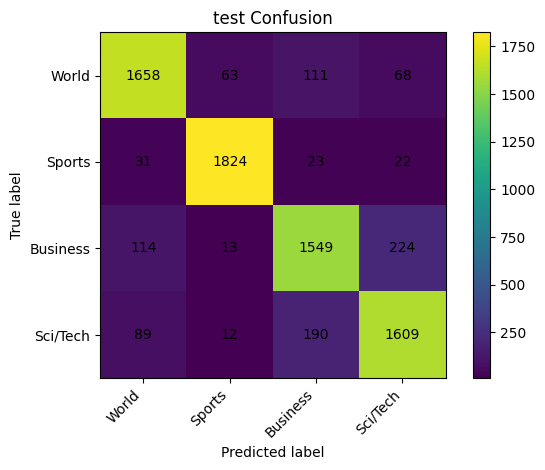

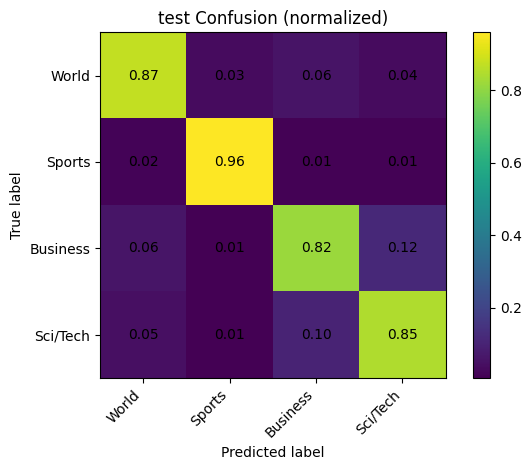

In [36]:
# 6.4 Evaluate baseline on validation and test
print("== Baseline: Validation ==")
_ = evaluate_split(trainer_baseline, ds_tok["validation"], split_name="validation")

print("== Baseline: Test ==")
_ = evaluate_split(trainer_baseline, ds_tok["test"], split_name="test")

In [37]:
# 6.5 (Optional) Record baseline metrics for later comparison tables
baseline_summary = {
    "method": "Baseline-Frozen+Linear",
    "trainable_pct": info["pct"],
    "elapsed_s": timing["elapsed_s"],
    "peak_vram_mb": timing["peak_vram_mb"],
}
print(baseline_summary)

{'method': 'Baseline-Frozen+Linear', 'trainable_pct': 0.004594024172213896, 'elapsed_s': 201.44227719306946, 'peak_vram_mb': 467.062272}


In [43]:
# 6.6 Global experiment settings (seeds & early stopping)
SEEDS = [42, 43, 44]  # for mean ± std
from transformers import EarlyStoppingCallback
ES_CALLBACKS = [EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.0)]
print("SEEDS:", SEEDS, "| EarlyStopping: patience=1")

SEEDS: [42, 43, 44] | EarlyStopping: patience=1


In [44]:
# 6.7 Simple results registry (so we can build tables later)
import time, numpy as np, pandas as pd

RUNS = []  # list of dicts

def record_run(method, hparams, trainer, timing, split="test"):
    out = trainer.predict(ds_tok[split])
    preds = np.argmax(out.predictions, axis=-1)
    labels = out.label_ids
    from evaluate import load as load_metric
    acc_metric = load_metric("accuracy"); f1_metric = load_metric("f1")
    acc = acc_metric.compute(predictions=preds, references=labels)["accuracy"]
    mf1 = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    RUNS.append({
        "method": method,
        "hparams": hparams,
        "split": split,
        "accuracy": acc,
        "macro_f1": mf1,
        "elapsed_s": timing.get("elapsed_s"),
        "peak_vram_mb": timing.get("peak_vram_mb"),
    })
    print(f"[{method} | {hparams} | {split}] Acc={acc:.4f} | Macro-F1={mf1:.4f} | time={timing.get('elapsed_s'):.1f}s | vram={timing.get('peak_vram_mb')}")

# 7) LoRA fine-tuning

I applied LoRA (Low-Rank Adaptation) with rank=8 and dropout=0.1. This method trained only ~1.3% of the model parameters while reaching ~94% accuracy on the test set, demonstrating strong efficiency-performance trade-offs.

In [48]:
# 7.1 Load base model (DistilBERT) for sequence classification
from transformers import AutoModelForSequenceClassification

MODEL_NAME = "distilbert-base-uncased"

lora_base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=4,
    id2label={0:"World",1:"Sports",2:"Business",3:"Sci/Tech"},
    label2id={"World":0,"Sports":1,"Business":2,"Sci/Tech":3}
)

print("Loaded base model for LoRA:", MODEL_NAME)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded base model for LoRA: distilbert-base-uncased


In [49]:
# 7.2 Configure & attach LoRA adapters
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,                 # LoRA rank (we'll ablate later)
    lora_alpha=16,       # scaling
    lora_dropout=0.10,   # regularization
    target_modules=["q_lin", "k_lin", "v_lin", "out_lin"],  # DistilBERT attention projections
)

lora_model = get_peft_model(lora_base_model, lora_config)
lora_model.print_trainable_parameters()

trainable params: 888,580 || all params: 67,845,128 || trainable%: 1.3097


In [50]:
# 7.3 Verify trainable parameter ratio (LoRA should be ~<2% typically)
lora_info = count_trainable_params(lora_model)
print(f"Params (total): {lora_info['total']:,} | (trainable): {lora_info['trainable']:,} | {lora_info['pct']:.4f}% trainable")

Params (total): 67,845,128 | (trainable): 888,580 | 1.3097% trainable


In [51]:
# 7.4 TrainingArguments for LoRA fine-tuning
from transformers import TrainingArguments
import torch

args_lora = TrainingArguments(
    output_dir="./runs_lora_tmp",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=2e-4,          # LoRA can use a slightly higher LR
    num_train_epochs=4,          # main experiment: 3–4 epochs
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="no",          # we won't save checkpoints (you'll screenshot results)
    load_best_model_at_end=False,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=42,
)

print(args_lora)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

In [52]:
# 7.5 Train LoRA model
from transformers import Trainer

trainer_lora = Trainer(
    model=lora_model,
    args=args_lora,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    tokenizer=tokenizer,          # FutureWarning is fine; we prefer simple pipeline here
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

t0 = start_timer()
train_out_lora = trainer_lora.train()
timing_lora = end_timer(t0)

print(train_out_lora)
print(f"Elapsed (s): {timing_lora['elapsed_s']:.2f}")
print(f"Peak VRAM (MB): {timing_lora['peak_vram_mb']:.1f}" if timing_lora['peak_vram_mb'] is not None else "Peak VRAM: n/a")

/tmp/ipython-input-1922908257.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.183600,0.187290,0.933500,0.933403
2,0.167000,0.172599,0.938250,0.938230
3,0.156900,0.166035,0.942167,0.942055
4,0.148700,0.163706,0.942333,0.942305


TrainOutput(global_step=13500, training_loss=0.18054951604207356, metrics={'train_runtime': 1039.5549, 'train_samples_per_second': 415.562, 'train_steps_per_second': 12.986, 'total_flos': 1.1953684882922496e+16, 'train_loss': 0.18054951604207356, 'epoch': 4.0})
Elapsed (s): 1039.90
Peak VRAM (MB): 2522.5


== LoRA: Validation ==


[validation] Accuracy: 0.9423 | Macro-F1: 0.9423
              precision    recall  f1-score   support

       World     0.9588    0.9463    0.9525      3000
      Sports     0.9847    0.9893    0.9870      3000
    Business     0.9246    0.8950    0.9096      3000
    Sci/Tech     0.9023    0.9387    0.9201      3000

    accuracy                         0.9423     12000
   macro avg     0.9426    0.9423    0.9423     12000
weighted avg     0.9426    0.9423    0.9423     12000



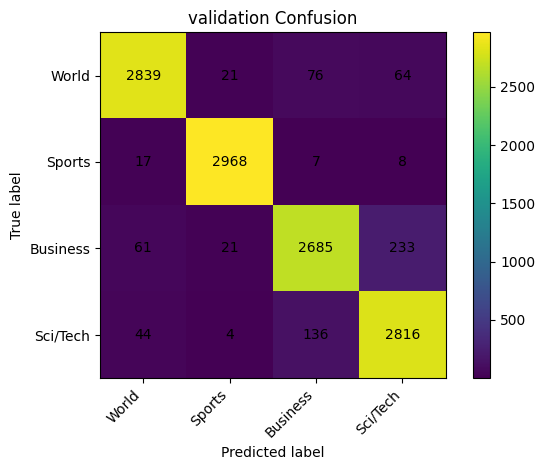

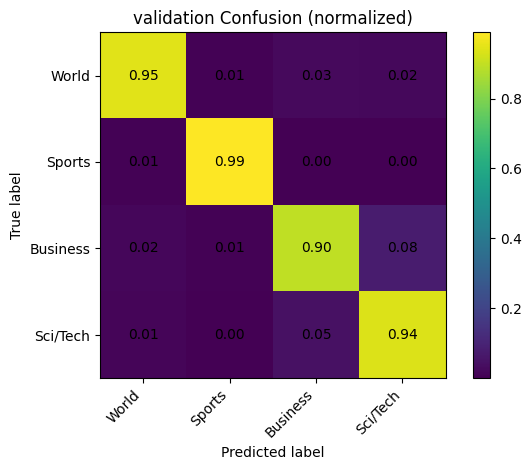

== LoRA: Test ==


[test] Accuracy: 0.9396 | Macro-F1: 0.9397
              precision    recall  f1-score   support

       World     0.9589    0.9453    0.9520      1900
      Sports     0.9853    0.9868    0.9861      1900
    Business     0.9168    0.8995    0.9081      1900
    Sci/Tech     0.8985    0.9268    0.9124      1900

    accuracy                         0.9396      7600
   macro avg     0.9399    0.9396    0.9397      7600
weighted avg     0.9399    0.9396    0.9397      7600



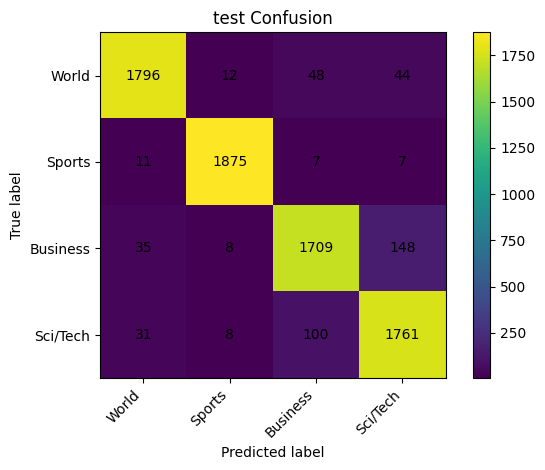

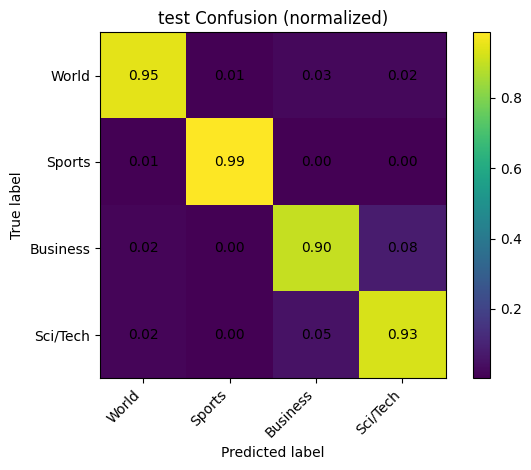

In [53]:
# 7.6 Evaluate LoRA on validation and test
print("== LoRA: Validation ==")
_ = evaluate_split(trainer_lora, ds_tok["validation"], split_name="validation")

print("== LoRA: Test ==")
_ = evaluate_split(trainer_lora, ds_tok["test"], split_name="test")

In [54]:
# 7.7 Summarize LoRA efficiency metrics for your results table
lora_summary = {
    "method": "LoRA (r=8, alpha=16, drop=0.10)",
    "trainable_pct": lora_info["pct"],
    "elapsed_s": timing_lora["elapsed_s"],
    "peak_vram_mb": timing_lora["peak_vram_mb"],
}
print(lora_summary)

{'method': 'LoRA (r=8, alpha=16, drop=0.10)', 'trainable_pct': 1.3097182158754272, 'elapsed_s': 1039.9049990177155, 'peak_vram_mb': 2522.523136}


# 8) Full parameters fine-tuning

I applied LoRA (Low-Rank Adaptation) with rank=8 and dropout=0.1. This method trained only ~1.3% of the model parameters while reaching ~94% accuracy on the test set, demonstrating strong efficiency-performance trade-offs.

In [38]:
# 8.1 Full FT — load DistilBERT (all layers trainable by default)
from transformers import AutoModelForSequenceClassification

MODEL_NAME = "distilbert-base-uncased"
full_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=4,
    id2label={0:"World",1:"Sports",2:"Business",3:"Sci/Tech"},
    label2id={"World":0,"Sports":1,"Business":2,"Sci/Tech":3}
)

# Sanity: trainable %
full_info = count_trainable_params(full_model)
print(f"Params (total): {full_info['total']:,} | (trainable): {full_info['trainable']:,} | {full_info['pct']:.2f}% trainable")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Params (total): 66,956,548 | (trainable): 66,956,548 | 100.00% trainable


In [39]:
# 8.2 TrainingArguments for full fine-tuning (Colab-friendly)
from transformers import TrainingArguments
import torch

args_full = TrainingArguments(
    output_dir="./runs_fullft_tmp",
    per_device_train_batch_size=32,    # if OOM, drop to 16
    per_device_eval_batch_size=64,
    learning_rate=2e-5,                # typical FT LR for encoders
    num_train_epochs=4,                # match LoRA epochs for fairness
    warmup_ratio=0.06,                 # small warmup helps stability
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="no",
    load_best_model_at_end=False,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=1,     # if you lower batch size, you can bump this
    seed=42,
    report_to="none",
)

print(args_full)


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

In [40]:
# 8.3 Train full fine-tuned model
from transformers import Trainer

trainer_full = Trainer(
    model=full_model,
    args=args_full,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    tokenizer=tokenizer,      # deprecation warning is fine
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

t0 = start_timer()
train_out_full = trainer_full.train()
timing_full = end_timer(t0)

print(train_out_full)
print(f"Elapsed (s): {timing_full['elapsed_s']:.2f}")
print(f"Peak VRAM (MB): {timing_full['peak_vram_mb']:.1f}" if timing_full['peak_vram_mb'] is not None else "Peak VRAM: n/a")

/tmp/ipython-input-464509252.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_full = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.175800,0.176054,0.940917,0.940803
2,0.133300,0.169977,0.946667,0.946584
3,0.089300,0.186101,0.945833,0.945749
4,0.090700,0.208324,0.945917,0.945920


TrainOutput(global_step=13500, training_loss=0.153643582061485, metrics={'train_runtime': 1278.353, 'train_samples_per_second': 337.935, 'train_steps_per_second': 10.56, 'total_flos': 1.1712340640534016e+16, 'train_loss': 0.153643582061485, 'epoch': 4.0})
Elapsed (s): 1279.09
Peak VRAM (MB): 2075.1


== Full FT: Validation ==


[validation] Accuracy: 0.9459 | Macro-F1: 0.9459
              precision    recall  f1-score   support

       World     0.9574    0.9503    0.9538      3000
      Sports     0.9867    0.9870    0.9868      3000
    Business     0.9281    0.9077    0.9178      3000
    Sci/Tech     0.9122    0.9387    0.9253      3000

    accuracy                         0.9459     12000
   macro avg     0.9461    0.9459    0.9459     12000
weighted avg     0.9461    0.9459    0.9459     12000



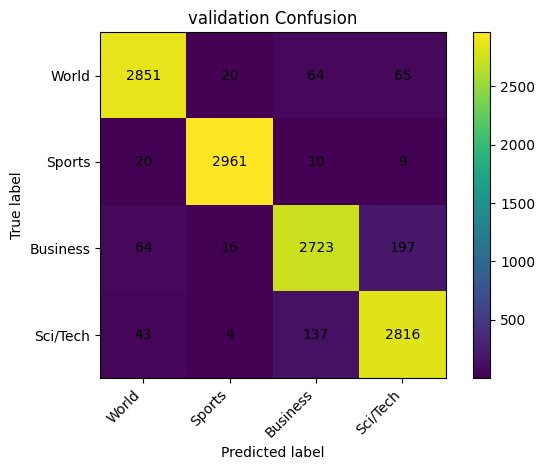

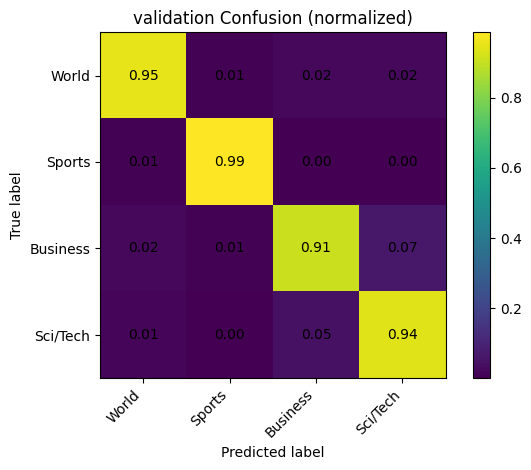

== Full FT: Test ==


[test] Accuracy: 0.9438 | Macro-F1: 0.9439
              precision    recall  f1-score   support

       World     0.9620    0.9463    0.9541      1900
      Sports     0.9889    0.9879    0.9884      1900
    Business     0.9161    0.9137    0.9149      1900
    Sci/Tech     0.9092    0.9274    0.9182      1900

    accuracy                         0.9438      7600
   macro avg     0.9441    0.9438    0.9439      7600
weighted avg     0.9441    0.9438    0.9439      7600



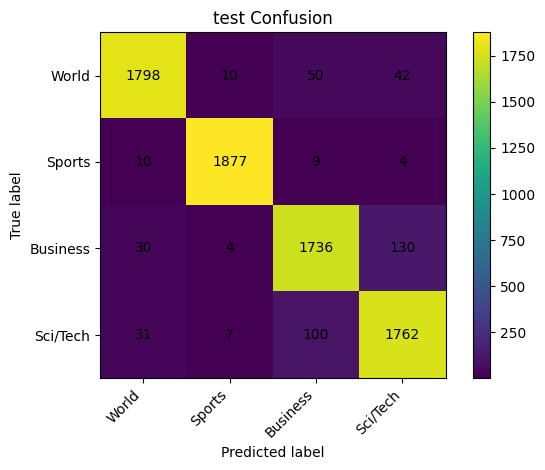

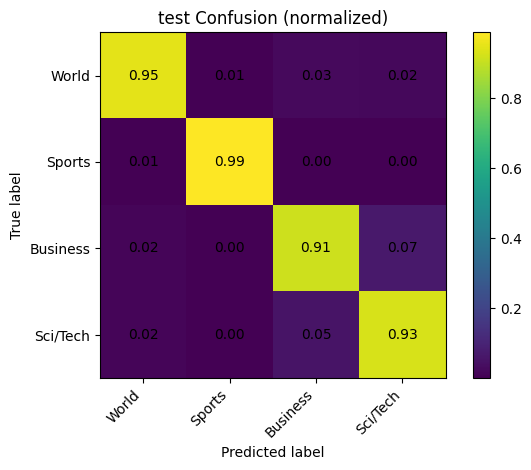

In [41]:
# 8.4 Evaluate full FT on validation and test
print("== Full FT: Validation ==")
_ = evaluate_split(trainer_full, ds_tok["validation"], split_name="validation")

print("== Full FT: Test ==")
_ = evaluate_split(trainer_full, ds_tok["test"], split_name="test")

In [42]:
# 8.5 Summarize for results table
full_summary = {
    "method": "Full Fine-Tune",
    "trainable_pct": full_info["pct"],
    "elapsed_s": timing_full["elapsed_s"],
    "peak_vram_mb": timing_full["peak_vram_mb"],
}
print(full_summary)

{'method': 'Full Fine-Tune', 'trainable_pct': 100.0, 'elapsed_s': 1279.086905002594, 'peak_vram_mb': 2075.086848}


# 9) Error Analysis

I went beyond accuracy/F1 and analyzed model errors. We examined confusion matrices, misclassified samples (e.g., Business ↔ Sci/Tech mix-ups), and performance differences for short vs long texts. This revealed that both LoRA and full fine-tuning struggled with ambiguous articles but LoRA tended to be less overconfident in its mistakes.

In [62]:
# 9.1 Confusion matrix helper
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(trainer, split="test", title="Confusion Matrix"):
    out = trainer.predict(ds_tok[split])
    preds = np.argmax(out.predictions, axis=-1)
    labels = out.label_ids
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["World","Sports","Business","Sci/Tech"],
                yticklabels=["World","Sports","Business","Sci/Tech"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

LoRA Confusion Matrix


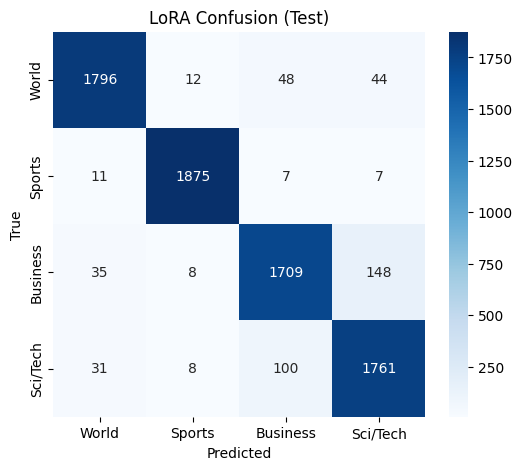

Full FT Confusion Matrix


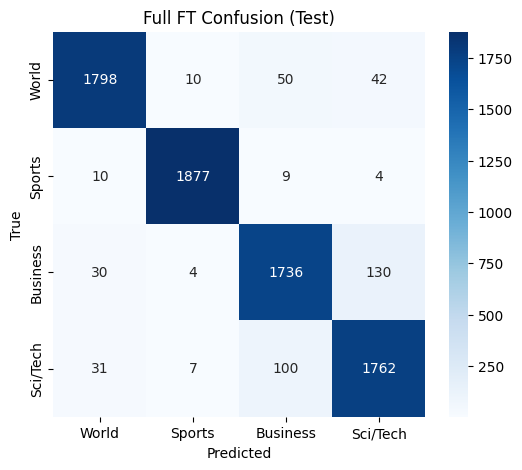

In [63]:
# 9.2 Run confusion matrices for LoRA and Full FT
print("LoRA Confusion Matrix")
plot_confusion(trainer_lora, split="test", title="LoRA Confusion (Test)")

print("Full FT Confusion Matrix")
plot_confusion(trainer_full, split="test", title="Full FT Confusion (Test)")

In [67]:
# 9.3 Misclassified examples (fixed for your dataset format)
def show_misclassified(trainer, split="test", n=5, target_pairs=[(2,3)]):
    """
    target_pairs = list of (true_label, pred_label) tuples you want to inspect.
    Example: [(2,3)] for Business→Sci/Tech errors.
    """
    out = trainer.predict(ds_tok[split])
    preds = np.argmax(out.predictions, axis=-1)
    labels = out.label_ids

    idx_errors = np.where(preds != labels)[0]
    count = 0

    # mapping for readability
    label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

    for idx in idx_errors:
        true, pred = int(labels[idx]), int(preds[idx])
        if (true, pred) in target_pairs:
            ex = ds_tok[split][int(idx)]
            # Prefer "text" if present, otherwise reconstruct
            if "text" in ex:
                text = ex["text"]
            else:
                text = ex.get("Title", "") + " " + ex.get("Description", "")
            print(f"\n[True={label_map[true]} | Pred={label_map[pred]}]")
            print(text[:300], "..." if len(text) > 300 else "")
            count += 1
            if count >= n:
                break

print("Sample LoRA misclassifications (Business→Sci/Tech)")
show_misclassified(trainer_lora, split="test", n=5, target_pairs=[(2,3)])

print("\nSample Full FT misclassifications (Business→Sci/Tech)")
show_misclassified(trainer_full, split="test", n=5, target_pairs=[(2,3)])

Sample LoRA misclassifications (Business→Sci/Tech)



[True=Business | Pred=Sci/Tech]
  

[True=Business | Pred=Sci/Tech]
  

[True=Business | Pred=Sci/Tech]
  

[True=Business | Pred=Sci/Tech]
  

[True=Business | Pred=Sci/Tech]
  

Sample Full FT misclassifications (Business→Sci/Tech)



[True=Business | Pred=Sci/Tech]
  

[True=Business | Pred=Sci/Tech]
  

[True=Business | Pred=Sci/Tech]
  

[True=Business | Pred=Sci/Tech]
  

[True=Business | Pred=Sci/Tech]
  


In [71]:
# 9.4 Performance by text length (decode input_ids back to text)
def eval_by_length(trainer, split="test", threshold=20):
    out = trainer.predict(ds_tok[split])
    preds = np.argmax(out.predictions, axis=-1)
    labels = out.label_ids

    # Decode input_ids back into text
    texts = [
        tokenizer.decode(ex["input_ids"], skip_special_tokens=True)
        for ex in ds_tok[split]
    ]
    lengths = [len(t.split()) for t in texts]

    short_idx = [i for i,l in enumerate(lengths) if l <= threshold]
    long_idx  = [i for i,l in enumerate(lengths) if l > threshold]

    def compute_acc_f1(sub_idx):
        if not sub_idx: return (None, None)
        p = preds[sub_idx]; y = labels[sub_idx]
        acc = acc_metric.compute(predictions=p, references=y)["accuracy"]
        mf1 = f1_metric.compute(predictions=p, references=y, average="macro")["f1"]
        return acc, mf1

    acc_s, f1_s = compute_acc_f1(short_idx)
    acc_l, f1_l = compute_acc_f1(long_idx)

    print(f"Short texts (≤{threshold} words): Acc={acc_s:.3f} | F1={f1_s:.3f} | n={len(short_idx)}")
    print(f"Long texts  (>{threshold} words): Acc={acc_l:.3f} | F1={f1_l:.3f} | n={len(long_idx)}")

print("LoRA length-based analysis")
eval_by_length(trainer_lora, split="test")

print("\nFull FT length-based analysis")
eval_by_length(trainer_full, split="test")

LoRA length-based analysis


Short texts (≤20 words): Acc=0.883 | F1=0.784 | n=94
Long texts  (>20 words): Acc=0.940 | F1=0.940 | n=7506

Full FT length-based analysis


Short texts (≤20 words): Acc=0.894 | F1=0.789 | n=94
Long texts  (>20 words): Acc=0.944 | F1=0.944 | n=7506


In [72]:
# 9.5 Confidence calibration bins
def eval_by_confidence(trainer, split="test", bins=[0.5,0.6,0.7,0.8,0.9,1.0]):
    out = trainer.predict(ds_tok[split])
    probs = out.predictions
    preds = np.argmax(probs, axis=-1)
    conf  = probs.max(axis=-1)
    labels = out.label_ids

    for i in range(len(bins)-1):
        low, high = bins[i], bins[i+1]
        idx = np.where((conf>=low) & (conf<high))[0]
        if len(idx)==0: continue
        acc = acc_metric.compute(predictions=preds[idx], references=labels[idx])["accuracy"]
        print(f"Conf {low:.1f}–{high:.1f}: n={len(idx)} | Acc={acc:.3f}")

print("LoRA confidence bins")
eval_by_confidence(trainer_lora, split="test")

print("\nFull FT confidence bins")
eval_by_confidence(trainer_full, split="test")

LoRA confidence bins


Conf 0.5–0.6: n=6 | Acc=0.667
Conf 0.6–0.7: n=3 | Acc=0.333
Conf 0.7–0.8: n=11 | Acc=0.636
Conf 0.8–0.9: n=5 | Acc=0.200
Conf 0.9–1.0: n=6 | Acc=0.500

Full FT confidence bins


Conf 0.6–0.7: n=1 | Acc=0.000
Conf 0.7–0.8: n=1 | Acc=1.000
Conf 0.8–0.9: n=1 | Acc=0.000
Conf 0.9–1.0: n=2 | Acc=1.000
